# Fill clarity label of test set using 3 annotators (majority vote)

In [22]:
from datasets import load_dataset
import numpy as np

np.random.seed(42)

In [23]:
# 1. Load the dataset (which already has train and test)
ds = load_dataset("ailsntua/QEvasion")

# 4. Assign everything to your variables
train_set = ds['train']
test_set  = ds['test']         # The original untouched test set

print(f"Train size: {len(train_set)}")
print(f"Test size:  {len(test_set)}")

Train size: 3448
Test size:  308


Class Distribution (Percentages):
                 Train  Test (Original)
clarity_label                          
Ambivalent       59.16            66.88
Clear Reply      30.51            25.65
Clear Non-Reply  10.32             7.47


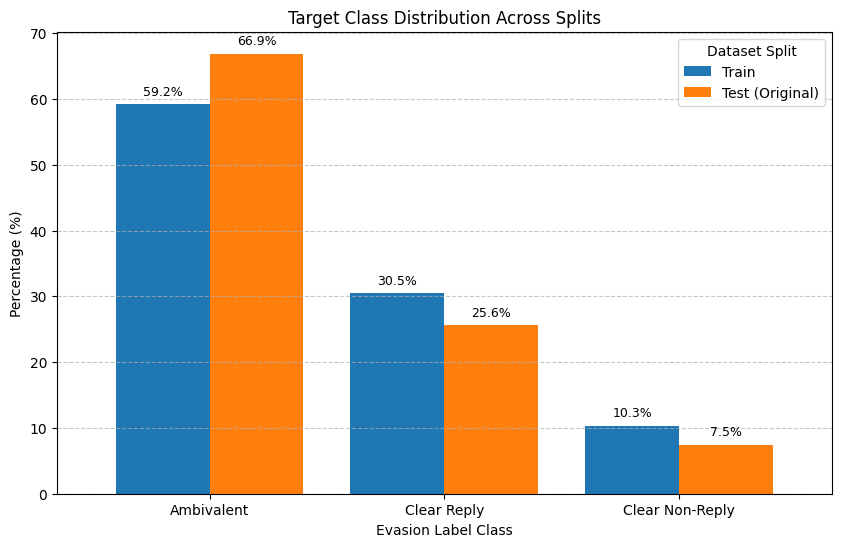

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Helper function to get distribution dataframe
def get_distribution(dataset_split, split_name):
    df = dataset_split.to_pandas()
    # counts = df['clarity_label'].value_counts() # Raw counts
    percents = df['clarity_label'].value_counts(normalize=True) * 100 # Percentages
    percents.name = split_name
    return percents

# 1. Calculate distributions for all 3 sets
dist_train = get_distribution(train_set, 'Train')
dist_test  = get_distribution(test_set,  'Test (Original)')

# 2. Combine into a single DataFrame for easy plotting
comparison_df = pd.concat([dist_train, dist_test], axis=1)

print("Class Distribution (Percentages):")
print(comparison_df.round(2)) # Print the table to console

# 3. Plotting
# Transpose so 'Splits' are on X-axis or Grouped Bar Chart
ax = comparison_df.plot(kind='bar', figsize=(10, 6), width=0.8)

plt.title("Target Class Distribution Across Splits")
plt.ylabel("Percentage (%)")
plt.xlabel("Evasion Label Class")
plt.xticks(rotation=0)
plt.legend(title="Dataset Split")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}%", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 9), 
                textcoords='offset points', fontsize=9)

plt.show()

### Fill Evasion Label from Annotators 1,2,3 columns

In [78]:
import random
from collections import Counter

# 1. Define function that returns TWO things: label + tie info
def consolidate_labels_tracked(example):
    # We remove the seed here so we can SEE if it's working (or keep it for reproducibility)
    random.seed(123) 
    
    votes = [example['annotator1'], example['annotator2'], example['annotator3']]
    counts = Counter(votes)
    most_common = counts.most_common()
    
    # Check for majority
    if most_common[0][1] > 1:
        final_label = most_common[0][0]
        is_tie = False  # Majority found
    else:
        # Tie-breaker: random choice
        final_label = random.choice(votes)
        is_tie = True   # Random choice was used
    
    # Return BOTH columns
    return {'evasion_label': final_label, 'is_tie': is_tie}

# 2. Apply and OVERWRITE the dataset
# We map it to the split you are working on (e.g., test_set or ds['train'])
test_set = test_set.map(consolidate_labels_tracked)

# 3. NOW calculate the count from the data itself
tie_count = sum(test_set['is_tie'])
total = len(test_set)

print(f"Total Rows: {total}")
print(f"Random Tie-Breakers Triggered: {tie_count}")
print(f"Percentage: {(tie_count/total)*100:.1f}%")

Map:   0%|          | 0/308 [00:00<?, ? examples/s]

Total Rows: 308
Random Tie-Breakers Triggered: 33
Percentage: 10.7%


In [79]:
# 1. Filter to get ONLY the rows where a random tie-breaker happened
tied_rows = test_set.filter(lambda x: x['is_tie'])

# 2. Convert to Pandas to see it as a clean table
# We select only the relevant columns to keep it readable
df_ties = tied_rows.select_columns(['annotator1', 'annotator2', 'annotator3', 'evasion_label']).to_pandas()

# 3. Print the results
print(f"Found {len(df_ties)} rows with ties (All 3 annotators disagreed):")
print("-" * 60)

# Print the whole table (if it's not too huge)
pd.set_option('display.max_rows', None) # Force pandas to show ALL rows
print(df_ties)

Filter:   0%|          | 0/308 [00:00<?, ? examples/s]

Found 33 rows with ties (All 3 annotators disagreed):
------------------------------------------------------------
             annotator1           annotator2           annotator3  \
0              Explicit     Claims ignorance              General   
1            Deflection              General             Implicit   
2            Deflection             Implicit              General   
3              Explicit              General             Implicit   
4            Deflection             Implicit              General   
5              Explicit              Dodging              General   
6              Explicit  Partial/half-answer             Implicit   
7               Dodging              General             Explicit   
8              Explicit              Dodging              General   
9               General           Deflection             Implicit   
10             Implicit              General           Deflection   
11             Explicit           Deflection             

Value Counts: Counter({'Explicit': 91, 'Implicit': 60, 'Dodging': 54, 'General': 52, 'Deflection': 21, 'Declining to answer': 12, 'Claims ignorance': 8, 'Partial/half-answer': 6, 'Clarification': 4})


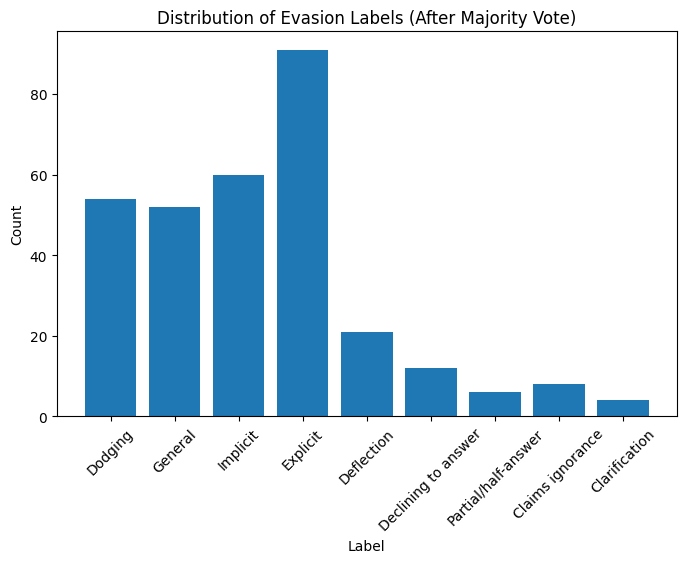

In [80]:
# --- 3. Visualize the Results ---
# Access the column directly from the HF dataset (it returns a list)
labels = test_set['evasion_label']

# Count the values
label_counts = Counter(labels)
print("Value Counts:", label_counts)

# Plot
plt.figure(figsize=(8, 5))
plt.bar(label_counts.keys(), label_counts.values())
plt.title("Distribution of Evasion Labels (After Majority Vote)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

Class Distribution (Percentages):
                     Train  Test (Original)
evasion_label                              
Explicit             30.51            29.55
Dodging              20.48            17.53
Implicit             14.15            19.48
General              11.19            16.88
Deflection           11.05             6.82
Declining to answer   4.21             3.90
Claims ignorance      3.45             2.60
Clarification         2.67             1.30
Partial/half-answer   2.29             1.95


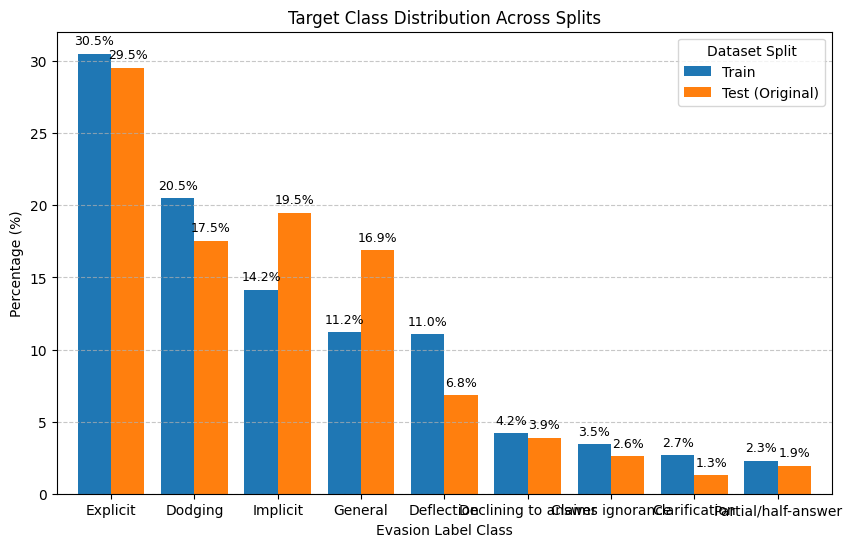

In [81]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Helper function to get distribution dataframe
def get_distribution(dataset_split, split_name):
    df = dataset_split.to_pandas()
    # counts = df['evasion_label'].value_counts() # Raw counts
    percents = df['evasion_label'].value_counts(normalize=True) * 100 # Percentages
    percents.name = split_name
    return percents

# 1. Calculate distributions for all 3 sets
dist_train = get_distribution(train_set, 'Train')
dist_test  = get_distribution(test_set,  'Test (Original)')

# 2. Combine into a single DataFrame for easy plotting
comparison_df = pd.concat([dist_train, dist_test], axis=1)

print("Class Distribution (Percentages):")
print(comparison_df.round(2)) # Print the table to console

# 3. Plotting
# Transpose so 'Splits' are on X-axis or Grouped Bar Chart
ax = comparison_df.plot(kind='bar', figsize=(10, 6), width=0.8)

plt.title("Target Class Distribution Across Splits")
plt.ylabel("Percentage (%)")
plt.xlabel("Evasion Label Class")
plt.xticks(rotation=0)
plt.legend(title="Dataset Split")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}%", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 9), 
                textcoords='offset points', fontsize=9)

plt.show()